In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

In [219]:
sns.set(rc={"figure.figsize": (8, 6)})
plt.style.use("fivethirtyeight")

# Data Loading and Cleaning

In [220]:
train_non_rand = pd.read_csv("data/non_rand_discount.csv", delimiter= ";")
train_non_rand.head()

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,spend_6m_eletronic,sales,discount,profit,age,gender,cust_state,tenure,sales_prediction_bins,sales_prediction
0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,3368.64,US$ 125.0,40.06,40,1.0,MA,6,8,1351.024765
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,2133.10,US$ 75.0,29.52,36,0.0,MG,10,4,1035.580387
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,2001.62,US$ 50.0,48.08,34,0.0,RJ,7,3,992.401825
3,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,1461.96,US$ 10.0,61.64,31,0.0,BA,7,1,919.720735
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,2743.72,US$ 100.0,34.44,32,1.0,PB,6,6,1176.485681


In [221]:
test_rand = pd.read_csv("data/random_data.csv")
test_rand.head()

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,spend_4m_eletronic,spend_5m_eletronic,spend_6m_eletronic,sales,discount,age,gender,cust_state,tenure,profit
0,0,0,0,0,0,0.0,25,50.0,0.0,0.0,...,0.0,0.0,0.0,1503.22,20.0,35,1.0,MA,23,55.16
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1798.30,60.0,29,1.0,MG,18,29.92
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1122.97,0.0,30,1.0,RJ,20,56.15
3,10,15,0,25,10,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1217.08,10.0,32,0.0,BA,20,50.85
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,966.58,0.0,30,0.0,PB,22,48.33


In [222]:
print(len(train_non_rand.columns))
train_non_rand.columns.to_list()[:4]

45


['spend_1m_baby', 'spend_2m_baby', 'spend_3m_baby', 'spend_4m_baby']

In [223]:
print(len(test_rand.columns))
test_rand.columns.to_list()[:4]

43


['spend_1m_baby', 'spend_2m_baby', 'spend_3m_baby', 'spend_4m_baby']

In [224]:
different_columns = [column for column in train_non_rand.columns.to_list() if column not in test_rand.columns.to_list()]
print(different_columns)

print(f"The non-random dataset has the shape: {train_non_rand.shape}")
print(f"The random dataset has the shape: {test_rand.shape}")


['sales_prediction_bins', 'sales_prediction']
The non-random dataset has the shape: (15000, 45)
The random dataset has the shape: (5000, 43)


In [225]:
train_non_rand.iloc[:, -10:].dtypes
test_rand.iloc[:, -10:].dtypes
test_rand["discount"]

0        20.0
1        60.0
2         0.0
3        10.0
4         0.0
        ...  
4995     10.0
4996     30.0
4997     10.0
4998    240.0
4999     10.0
Name: discount, Length: 5000, dtype: float64

In [226]:
discount_temp = train_non_rand["discount"].str.split(" ", expand=True)
train_non_rand["discount"] = pd.to_numeric(discount_temp[1])
train_non_rand.iloc[:, -10:].dtypes

spend_6m_eletronic       float64
sales                    float64
discount                 float64
profit                   float64
age                        int64
gender                   float64
cust_state                object
tenure                     int64
sales_prediction_bins      int64
sales_prediction         float64
dtype: object

# Data exploration

[Text(0.5, 1.0, 'Non-random Data')]

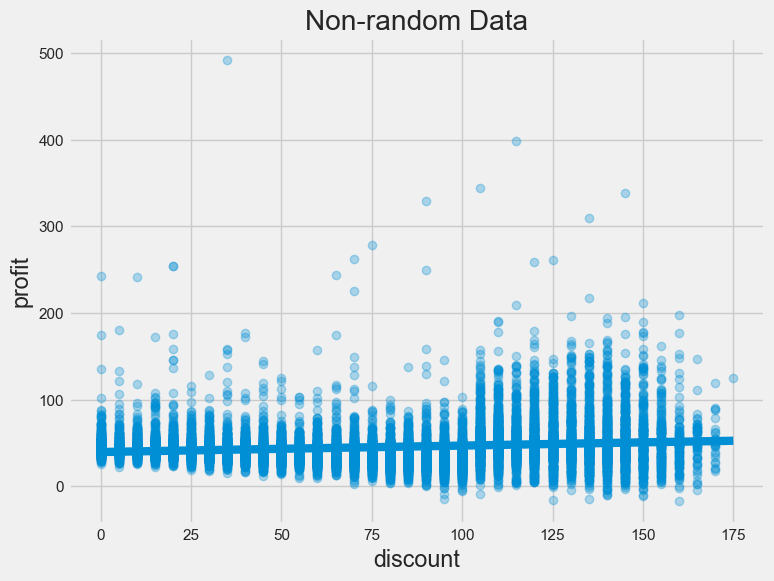

In [227]:
sns.regplot(data=train_non_rand,
                x="discount",
                y="profit",
                scatter_kws={"alpha": 0.3}
                ).set(title="Non-random Data")

[Text(0.5, 1.0, 'Random Data')]

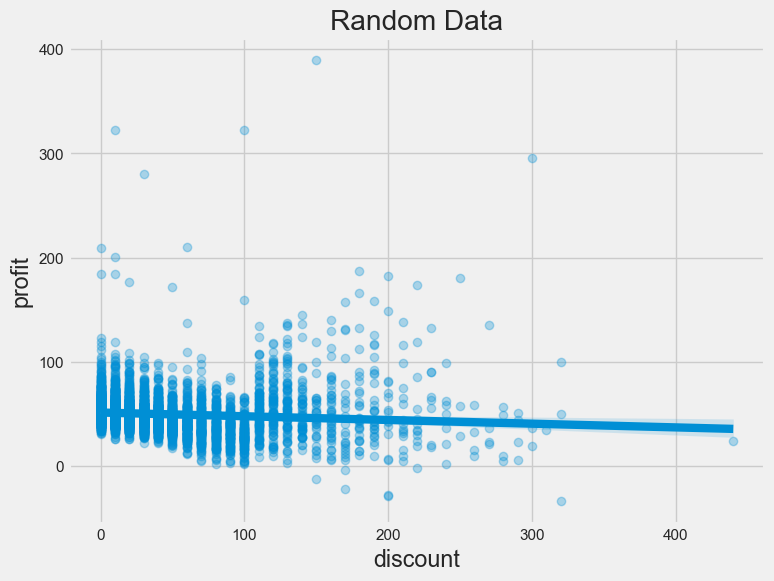

In [228]:
sns.regplot(data=test_rand,
                x="discount",
                y="profit",
                scatter_kws={"alpha": 0.3}
                ).set(title="Random Data")

As we have seen before, the non-randomized data gives us a flat or even slightly positive correlation between discount and profits. We know this isn't the causal relationship. On the other hand, the randomized data set has a slight negative correlation which is consistent with our analysis so far. This relationship can be considered to be causal.

Next, we calculate the slope coefficient of the regression line of the outcome on treatment. This is also known as the linear causal effect.

In [229]:
# linear causal effect
def elast(data: pd.DataFrame, outcome: str, treatment: str):
    covariance_matrix = np.cov(data[outcome], data[treatment])
    covariance = covariance_matrix[0, 1]
    variance_treatment = covariance_matrix[1, 1] 
    linear_causal_effect = covariance / variance_treatment
    
    return linear_causal_effect

ate_discount_sales = elast(test_rand, "sales", "discount")
ate_discount_profit = elast(test_rand, "profit", "discount")

print("On randomized data -")
print(f"ATE of discount on sales: {ate_discount_sales}")
print(f"ATE of discount on profits: {ate_discount_profit}")

ate_discount_sales_nr = elast(train_non_rand, "sales", "discount")
ate_discount_profit_nr = elast(train_non_rand, "profit", "discount")

print("On non-randomized data -")
print(f"ATE of discount on sales: {ate_discount_sales_nr}")
print(f"ATE of discount on profits: {ate_discount_profit_nr}")


On randomized data -
ATE of discount on sales: 19.28676541602874
ATE of discount on profits: -0.03566112670736015
On non-randomized data -
ATE of discount on sales: 21.924806313467577
ATE of discount on profits: 0.0743147500562718


As noted before, and shown above, the ATE of discount on profits for the randomized data is negative whilst the same for non-randomized data is positive. We have a positive bias on profits in the non-randomized data.

We can verify the ATE using regression.

In [230]:
model = smf.ols("profit ~ discount", data=test_rand).fit()
print(model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     51.3226      0.390    131.725      0.000      50.559      52.086
discount      -0.0357      0.006     -6.058      0.000      -0.047      -0.024


We have a similar coefficient on discount and the result is statistically significant.

## Comments
Currently, the company is giving discounts to **all** customers, which, on average, is resulting in less profits. However, this is not the only option - we might be able to find subgroups of customers where the causal effect is positive. If we can then give discounts to only those customers, the e-commerce company can still make money by giving discounts. 

# Personalization

Usually when company's approach a problem like personlization, they turn to machine learning. In fact, we have seen the very same in the dataset with `sales_prediction` and `sales_prediction_bins`. The company is providing higher discounts to customers predicted to result in higher sales.

## ML Model
We train a ML model to predict sales from customer level features. Note that we removed the `discount` feature as we don't know the discount level given before making sales predictions.

In [231]:
X = list(train_non_rand.drop(columns=['sales', 'profit', 'discount', 'cust_state', 'sales_prediction_bins', 'sales_prediction']).columns)
y = "sales"

model = LGBMRegressor() # working with defaults
model.fit(train_non_rand[X], train_non_rand[y])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 39
[LightGBM] [Info] Start training from score 2509.492501


LGBMRegressor()

In [232]:
train_predictions = train_non_rand.assign(
    prediction = model.predict(train_non_rand[X])
)

test_predictions = test_rand.assign(
    prediction = model.predict(test_rand[X])
)

In [233]:
r2_train = r2_score(train_predictions["sales"], train_predictions["prediction"])
r2_test = r2_score(test_predictions["sales"], test_predictions["prediction"])

print(f"The R2 score for training is: {r2_train:.2f}")
print(f"The R2 score for test is: {r2_test:.2f}")

The R2 score for training is: 0.89
The R2 score for test is: 0.44


Both train and test set have decent performance. While there is clearly a gap between training and test performance, that is probably due to different discount regimes and not a case of overfitting. Once again, we are not particularly interested in predictive performance here. This is mostly to confirm that the model is not completely off.

In [234]:
sorted_by_prediction_test = test_predictions.sort_values(by="prediction", ascending=False)

# conditioning on the top 1000 customers with high sales predictions
top_1000_preds = sorted_by_prediction_test.head(1000)
bottom_1000_preds = sorted_by_prediction_test.tail(1000)

elasticity_top1000 = elast(top_1000_preds, "profit", "discount")
elasticity_bottom1000 = elast(bottom_1000_preds, "profit", "discount")

print(f"the CATE for the top 1000 customers with high sales predictions is: {elasticity_top1000:.2f}")
print(f"the CATE for the bottom 1000 customers with high sales predictions is: {elasticity_bottom1000:.2f}")

the CATE for the top 1000 customers with high sales predictions is: -0.10
the CATE for the bottom 1000 customers with high sales predictions is: -0.28


## Comments
When we arrange our dataset based on predicted sales and select the top 1,000 customers (those with the highest predictions), we calculate their price elasticity to be -0.1. Conversely, when we analyze the bottom 1,000 customers according to the same ranking, their elasticity is found to be -0.3. This observation implies two key insights: firstly, **offering discounts does not lead to profitability** in any customer segment as defined by sales predictions. Secondly, **the sensitivity of a customer's profit to discounts decreases as their sales prediction increases.** In simpler terms, customers predicted to have lower sales are more negatively affected by discounts in terms of profit.

# Personalization Strategies

Note the simplifying step: we convert the treatment to a binary $discount > 30$. Converting a continous treatment to a binary is a common practice in the industry. It simplifies the causal inference problem and many causal inference techniques only work with binary or discrete treatments. Nonetheless, it serves a solid starting point.

### Effect by Segment Step

In [235]:
test_predictions["binary_discount"] = (test_predictions["discount"] > 30).astype(int)

def treatment_effect(data: pd.DataFrame, treatment_col: str, outcome_col: str):
    average_profits = data.groupby(treatment_col)[outcome_col].mean()
    ate = average_profits[1] - average_profits[0]
    return ate

ate = treatment_effect(test_predictions, "binary_discount", "profit")
print(f"Average treatment effect on the test set: {ate:.2f}")

Average treatment effect on the test set: -7.96


In [236]:
def effect_by_segment(df: pd.DataFrame,
                      segment_column: str,
                      num_segments: int = 10):
    segment_band_column = f"{segment_column}_band"
    df_with_segments = df.assign(**{segment_band_column: pd.qcut(df[segment_column], q=num_segments)})
    grouped = df_with_segments.groupby(segment_band_column)

    effect_by_segment = grouped.apply(lambda x: treatment_effect(x, "binary_discount", "profit"))

    return effect_by_segment

/var/folders/97/f7cwxzrn1bbg7whsq729sxxc0000gn/T/ipykernel_5845/1135249879.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_with_segments.groupby(segment_band_column)


Text(0, 0.5, 'Treatment Effect')

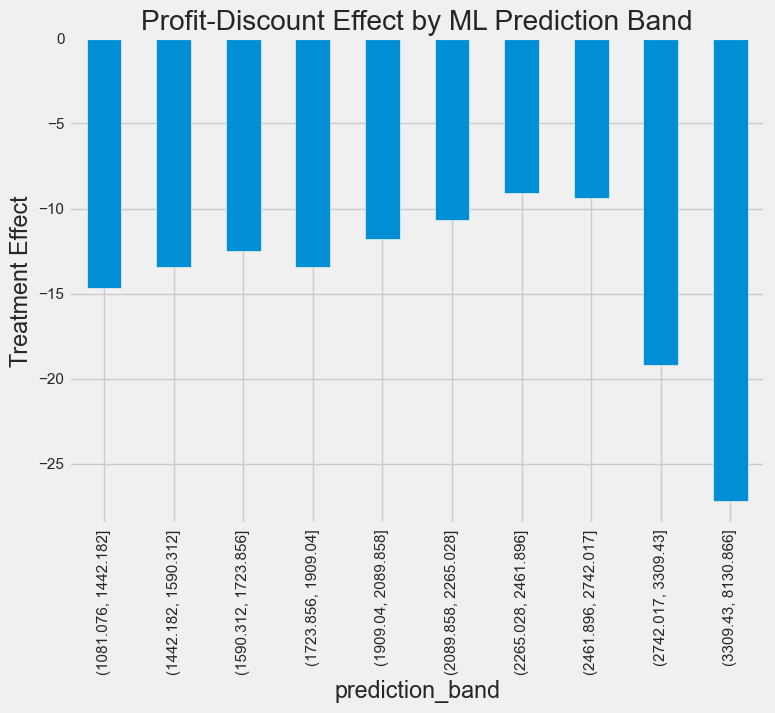

In [237]:
effect_by_segment(test_predictions,
                  "prediction",
                  10).plot.bar(title="Profit-Discount Effect by ML Prediction Band")
plt.ylabel("Treatment Effect")

/var/folders/97/f7cwxzrn1bbg7whsq729sxxc0000gn/T/ipykernel_5845/1135249879.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_with_segments.groupby(segment_band_column)


Text(0, 0.5, 'Treatment Effect')

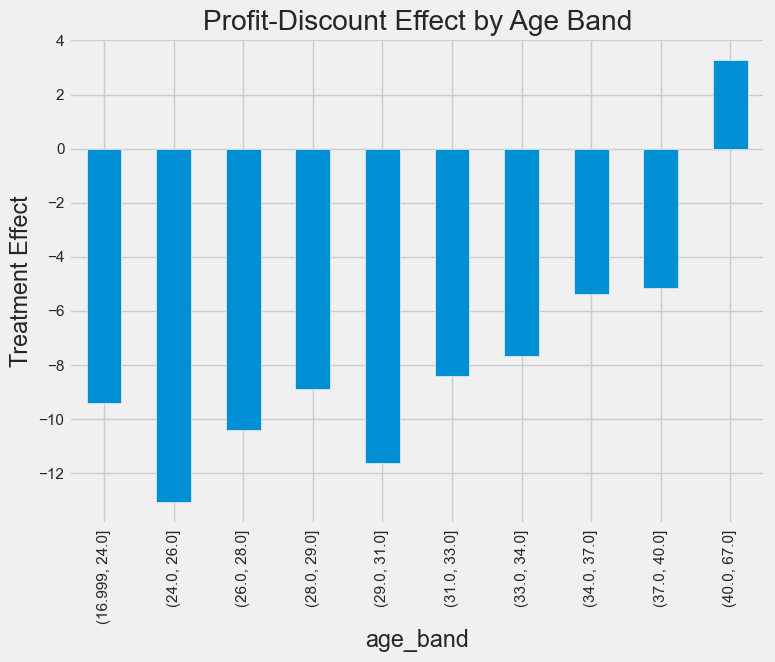

In [238]:
effect_by_segment(test_predictions,
                  "age",
                  10).plot.bar(title="Profit-Discount Effect by Age Band")
plt.ylabel("Treatment Effect")

/var/folders/97/f7cwxzrn1bbg7whsq729sxxc0000gn/T/ipykernel_5845/1135249879.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_with_segments.groupby(segment_band_column)


Text(0, 0.5, 'Treatment Effect')

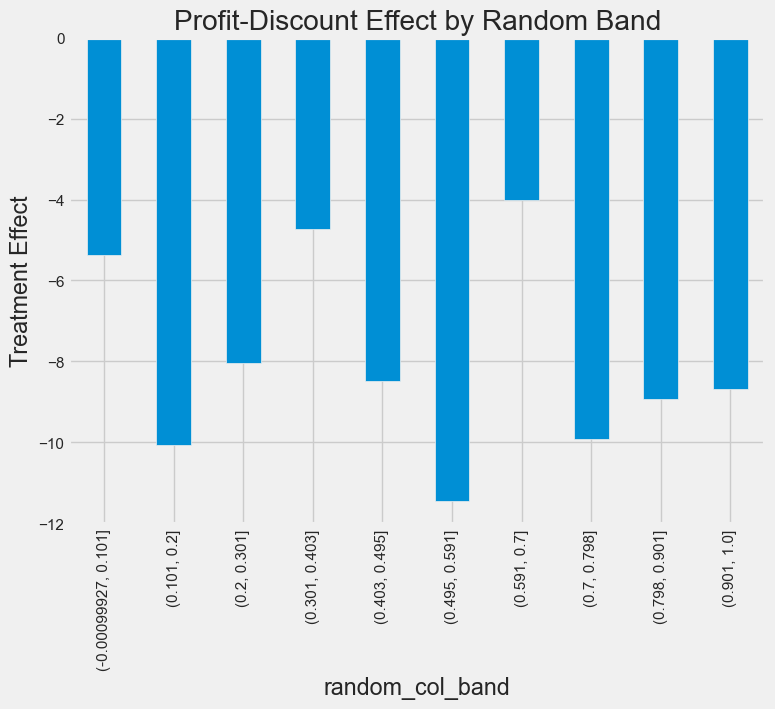

In [239]:
np.random.seed(69)
random_col = np.random.uniform(0, 1, test_rand.shape[0])

effect_by_segment(test_predictions.assign(random_col = random_col),
                  "random_col",
                  10).plot.bar(title="Profit-Discount Effect by Random Band")
plt.ylabel("Treatment Effect")

## Comments
**Segmenting customers by the sales prediction model results in no segment where more discount leads to more profit** - the treatment effect is always negative. 

When we look at the age segments, we notice that the segment (40 to 67) has a positive treatment effect. **This means that if we explore age segementation, we can find segments where discounts are profitable**.

Finally, our **random number segments resulted in treatment effect that varies around the average treatment** effect we found (-7.96) for the entire test set. This makes sense, since each segment defined by the uniform random number segment should behave like a representative sample of the entire test set.

### Cumulative Effect Curve

In [240]:
def cumulative_treatment_effect(data: pd.DataFrame,
                                segment_column: str,
                                num_segments: int):
    """Calculates the cumulative treatment effect curve.

    Args:
        data (pd.DataFrame): _description_
        segment_column (str): _description_
        num_segments (int): _description_

    Returns:
        np.array: array containing the estimated treatment effect for each segment 
    """
    ordered_df = data.sort_values(by=segment_column, ascending=False).reset_index(drop=True)

    indices = (np.arange(1, num_segments + 1) / num_segments * len(ordered_df)).astype(int)

    treatment_effects = np.zeros(num_segments)

    for i, index in enumerate(indices):
        segment = ordered_df.iloc[:index]
        treatment_effects[i] = treatment_effect(data=segment,
                                                treatment_col="binary_discount",
                                                outcome_col="profit")
    
    return treatment_effects

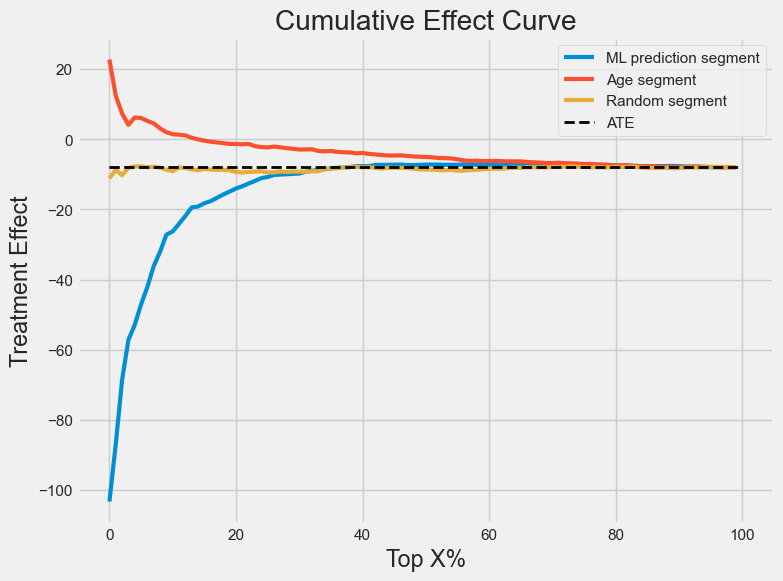

In [241]:
cte_prediction = cumulative_treatment_effect(test_predictions, "prediction", 100)
cte_age = cumulative_treatment_effect(test_predictions, "age", 100)
cte_rand = cumulative_treatment_effect(test_predictions.assign(random_col = random_col),
                                       "random_col",
                                       100)

plt.plot(cte_prediction, label="ML prediction segment", lw=3)
plt.plot(cte_age, label="Age segment", lw=3)
plt.plot(cte_rand, label="Random segment", lw=3)
plt.hlines(ate, 0, 100, linestyles="--", color="black", label="ATE", lw=2)
plt.ylabel("Treatment Effect")
plt.xlabel("Top X%")
plt.title("Cumulative Effect Curve")

plt.legend()

The cumulative effect curve tells a similar story. Ordering customers by sale prediction always yields a negative treatment effect. However, ordering by age, we see that the top 20% older customers have a positive discount effect on price. Thus, **simply segmenting custoemrs by age and sending discounts to older customers is a better personalization strategy than a complex ML model.**

### Cumulative Gain Curve

In [242]:
def cumulative_treatment_gain(data: pd.DataFrame,
                                segment_column: str,
                                num_segments: int):
    """Calculates the cumulative treatment effect curve.

    Args:
        data (pd.DataFrame): _description_
        segment_column (str): _description_
        num_segments (int): _description_

    Returns:
        np.array: array containing the estimated treatment effect for each segment 
    """
    ordered_df = data.sort_values(by=segment_column, ascending=False).reset_index(drop=True)

    percentages = (np.arange(1, num_segments + 1)) / num_segments
    indices = (percentages * len(ordered_df)).astype(int)

    treatment_gains = np.zeros(num_segments)

    for i, index in enumerate(indices):
        segment = ordered_df.iloc[:index]
        treatment_gains[i] = treatment_effect(data=segment,
                                                treatment_col="binary_discount",
                                                outcome_col="profit")

    return treatment_gains * percentages

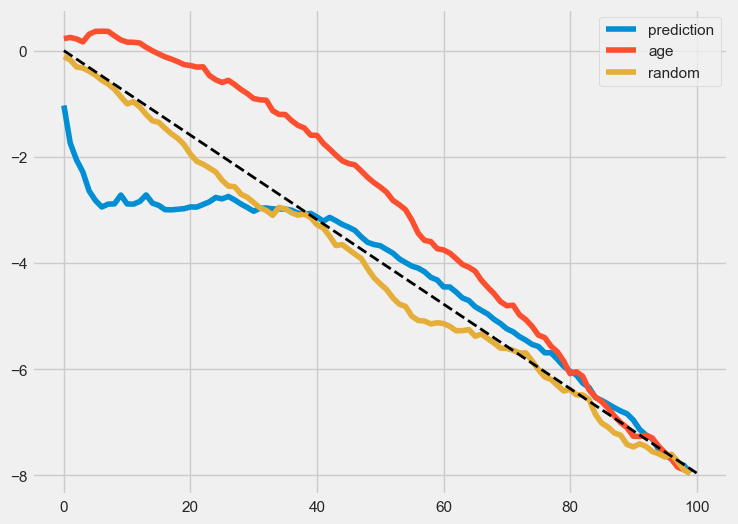

In [243]:
gain_prediction = cumulative_treatment_gain(test_predictions, "prediction", 100)
gain_age = cumulative_treatment_gain(test_predictions, "age", 100)
gain_rand = cumulative_treatment_gain(test_predictions.assign(random_col = random_col),
                                       "random_col",
                                       100)

plt.plot(gain_prediction, label="prediction")
plt.plot(gain_age, label="age")
plt.plot(gain_rand, label="random")
plt.plot([0, 100], [0, ate], linestyle="--", color="black", lw=2)
plt.legend()

The cumulative gain tells a similar story. This is a harder curve to interpret - the higher the curve (to the top right corner), the better the personalization. We see clearly that personalizing by age is a much better idea than by ML model that predicts sales. The curve is similar in concept to the ROC curve.

# Continuous Treatment Effect

In the continuous case, we can think of the treatement effect as the linear coefficient from the regression line:
$$
Y_i = \alpha + \tau T_i + e_i
$$
This coefficient tells us how much we should expect the outcome to increase if we increase the treatment by one unit. This is the same as the `elast` function defined above, which is the general case of the `treatment_effect` function. 

We will think of treatment effect heterogeneity as the regression slopes.

In [244]:
# copied from previous cell
def elast(data: pd.DataFrame, outcome: str, treatment: str):
    covariance_matrix = np.cov(data[outcome], data[treatment])
    covariance = covariance_matrix[0, 1]
    variance_treatment = covariance_matrix[1, 1] 
    linear_causal_effect = covariance / variance_treatment
    
    return linear_causal_effect

def elasticity_by_segment(df: pd.DataFrame,
                          segment_column: str,
                          num_segments: int = 100):
    segment_band_column = f"{segment_column}_band"
    df_with_segments = df.assign(**{segment_band_column: pd.qcut(df[segment_column], q=num_segments)})
    grouped = df_with_segments.groupby(segment_band_column)

    effect_by_segment = grouped.apply(lambda x: elast(x, "profit", "discount"))

    return effect_by_segment

/var/folders/97/f7cwxzrn1bbg7whsq729sxxc0000gn/T/ipykernel_5845/1358689627.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_with_segments.groupby(segment_band_column)
/var/folders/97/f7cwxzrn1bbg7whsq729sxxc0000gn/T/ipykernel_5845/1358689627.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_with_segments.groupby(segment_band_column)
/var/folders/97/f7cwxzrn1bbg7whsq729sxxc0000gn/T/ipykernel_5845/1358689627.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

[]

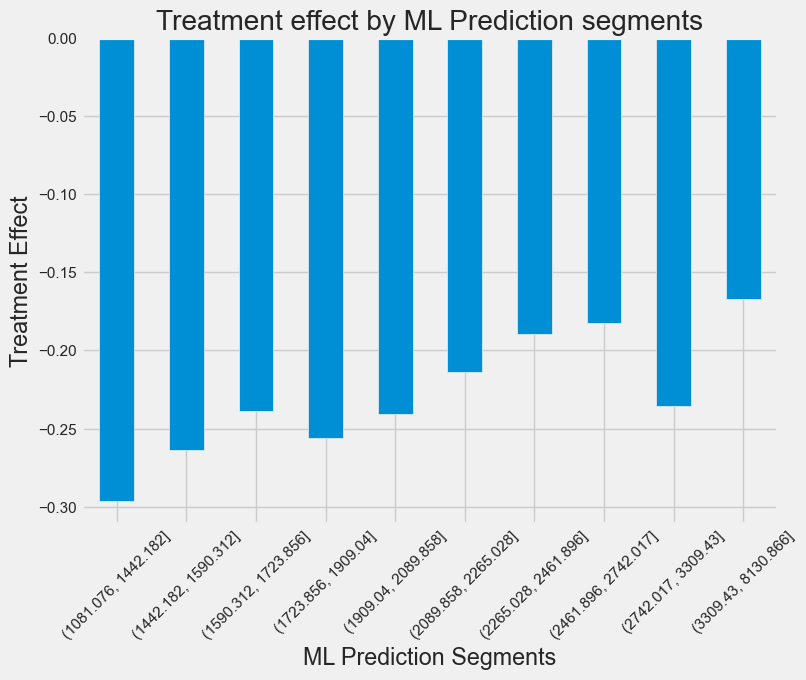

In [260]:
elasticity_by_prediction = elasticity_by_segment(test_predictions, "prediction", 10)
elasticity_by_age = elasticity_by_segment(test_predictions, "age", 10)
elasticity_by_random = elasticity_by_segment(test_predictions.assign(random_col=random_col),
                                             "random_col",
                                             10)

elasticity_by_prediction.plot.bar(title="Treatment effect by ML Prediction segments")
plt.ylabel("Treatment Effect")
plt.xlabel("ML Prediction Segments")
plt.xticks(rotation=45)
# plt.savefig("images/te_ml_predictions.jpg")
plt.plot()


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '(16.999, 24.0]'),
  Text(1, 0, '(24.0, 26.0]'),
  Text(2, 0, '(26.0, 28.0]'),
  Text(3, 0, '(28.0, 29.0]'),
  Text(4, 0, '(29.0, 31.0]'),
  Text(5, 0, '(31.0, 33.0]'),
  Text(6, 0, '(33.0, 34.0]'),
  Text(7, 0, '(34.0, 37.0]'),
  Text(8, 0, '(37.0, 40.0]'),
  Text(9, 0, '(40.0, 67.0]')])

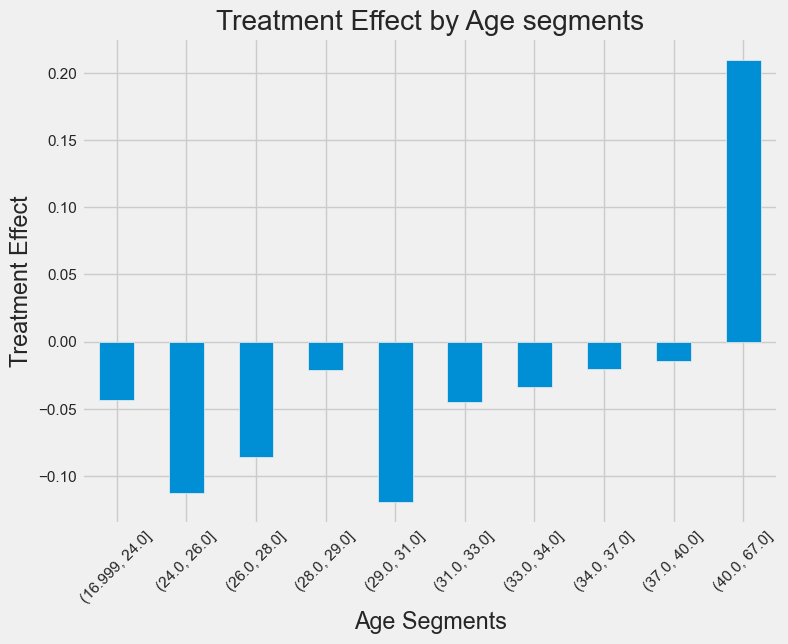

In [261]:
elasticity_by_age.plot.bar(title="Treatment Effect by Age segments")
plt.ylabel("Treatment Effect")
plt.xlabel("Age Segments")
plt.xticks(rotation=45)

<Axes: title={'center': 'Treatment effect by Random segments'}, xlabel='random_col_band'>

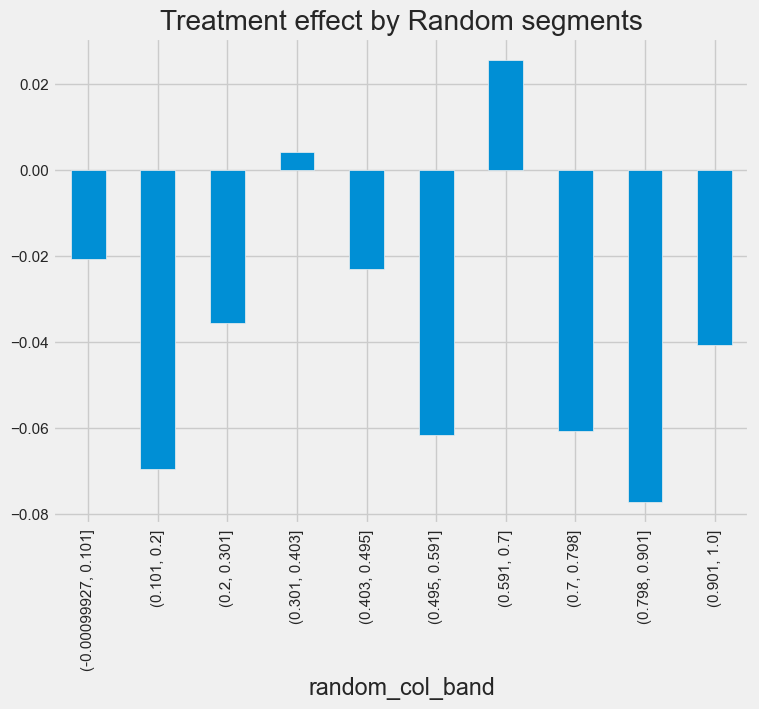

In [247]:
elasticity_by_random.plot.bar(title="Treatment effect by Random segments")

The results are in line with the binary version. ML prediction segments are never positive. We get a positive treatment effect by Age again. **If we look at the last segment, we expect profit to increase by \$0.2 for every \$1.0 invested in discounts.** Finally, whilst the random segments have a few positive treatment effect, the numbers are very small and likely due to noise.

In [248]:
def cumulative_continuous_treatment_effect(data: pd.DataFrame,
                                segment_column: str,
                                num_segments: int):
    """Calculates the cumulative treatment effect curve.
    
    Returns:
        np.array: array containing the estimated treatment effect for each segment 
    """
    ordered_df = data.sort_values(by=segment_column, ascending=False).reset_index(drop=True)

    indices = (np.arange(1, num_segments + 1) / num_segments * len(ordered_df)).astype(int)

    treatment_effects = np.zeros(num_segments)

    for i, index in enumerate(indices):
        segment = ordered_df.iloc[:index]
        treatment_effects[i] = elast(data=segment,
                                     treatment="discount",
                                     outcome="profit")
    
    return treatment_effects

In [249]:
cte_continuous_prediction = cumulative_continuous_treatment_effect(test_predictions, "prediction", 100)
cte_continuous_age = cumulative_continuous_treatment_effect(test_predictions, "age", 100)
cte_continuous_random = cumulative_continuous_treatment_effect(test_predictions.assign(random_col=random_col),
                                                               "random_col",
                                                               100)

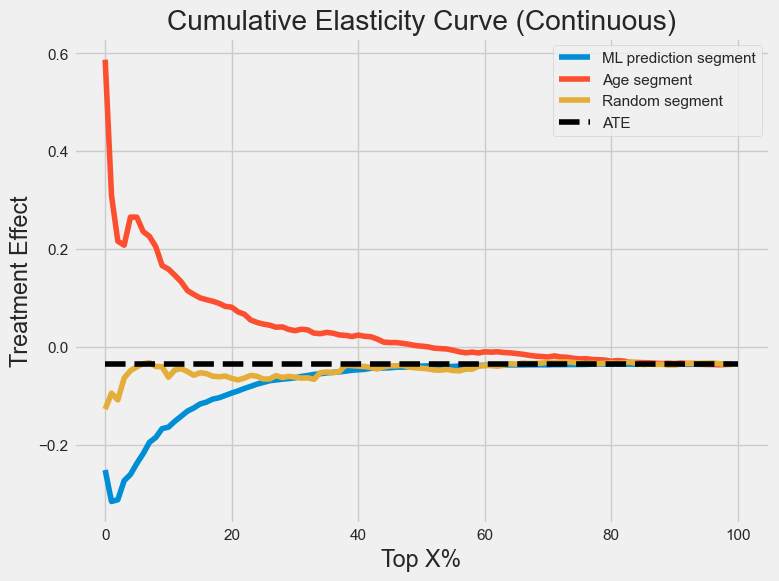

In [250]:
plt.plot(cte_continuous_prediction, label="ML prediction segment")
plt.plot(cte_continuous_age, label="Age segment")
plt.plot(cte_continuous_random, label="Random segment")
plt.hlines(elast(test_predictions, "profit", "discount"), 0, 100, linestyles="--", color="black", label="ATE")
plt.ylabel("Treatment Effect")
plt.xlabel("Top X%")
plt.title("Cumulative Elasticity Curve (Continuous)")

plt.legend()

The cumulative elasticity curve tells a similar story. Ordering customers by age, the top 40% older customers have a positive discount effect on profit.

In [251]:
def cumulative_continous_treatment_gain(data: pd.DataFrame,
                                segment_column: str,
                                num_segments: int):
    """Calculates the cumulative treatment effect curve.

    Args:
        data (pd.DataFrame): _description_
        segment_column (str): _description_
        num_segments (int): _description_

    Returns:
        np.array: array containing the estimated treatment effect for each segment 
    """
    ordered_df = data.sort_values(by=segment_column, ascending=False).reset_index(drop=True)

    percentages = (np.arange(1, num_segments + 1)) / num_segments
    indices = (percentages * len(ordered_df)).astype(int)

    treatment_gains = np.zeros(num_segments)

    for i, index in enumerate(indices):
        segment = ordered_df.iloc[:index]
        treatment_gains[i] = elast(data=segment,
                                    treatment="discount",
                                    outcome="profit")

    return treatment_gains * percentages

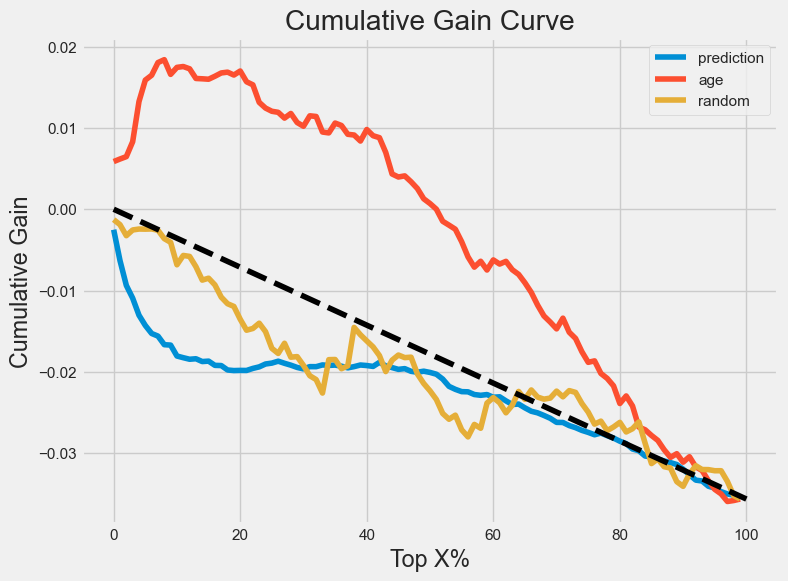

In [252]:
gain_continuous_prediction = cumulative_continous_treatment_gain(test_predictions, "prediction", 100)
gain_continuous_age = cumulative_continous_treatment_gain(test_predictions, "age", 100)
gain_continous_rand = cumulative_continous_treatment_gain(test_predictions.assign(random_col = random_col),
                                       "random_col",
                                       100)

plt.plot(gain_continuous_prediction, label="prediction")
plt.plot(gain_continuous_age, label="age")
plt.plot(gain_continous_rand, label="random")
plt.plot([0, 100], [0, elast(test_predictions, "profit", "discount")], linestyle="--", color="black")
plt.title("Cumulative Gain Curve")
plt.ylabel("Cumulative Gain")
plt.xlabel("Top X%")
plt.legend()

# Causal Model for Personalization

When we have randomized data, we can use linear regression to estimate the treatment effect (TE) of discount on profits.
$$
Profit_i = \beta_0 + \beta_1 Discount_i + e_i
$$

Where $\beta_1$ can be viewed as the TE. When we add $Age$ to the model, we get:
$$
Profit_i = \beta_0 + \beta_1 Age_i + \beta_2Discount_i +  \beta_3 Discount_iAge_i + e_i
$$

The treatment effect becomes:
$$
TE_i = \beta_2 + \beta_3Age_i
$$

By allowing TE to change by $Age$ we create a treatment effect heterogeneity model using linear regression. For our case, we also include `tenure` and `cust_state`.

In [253]:
model = smf.ols(
    "profit ~ discount*(tenure + age + C(cust_state))",
    data = train_non_rand
).fit()

test_treatment_effect = model.predict(test_predictions) - model.predict(test_predictions.assign(discount=test_predictions["discount"] - 1))
test_predictions["treatment_effect_model"] = test_treatment_effect

/var/folders/97/f7cwxzrn1bbg7whsq729sxxc0000gn/T/ipykernel_5845/1358689627.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_with_segments.groupby(segment_band_column)


Text(0, 0.5, 'Treatment effect')

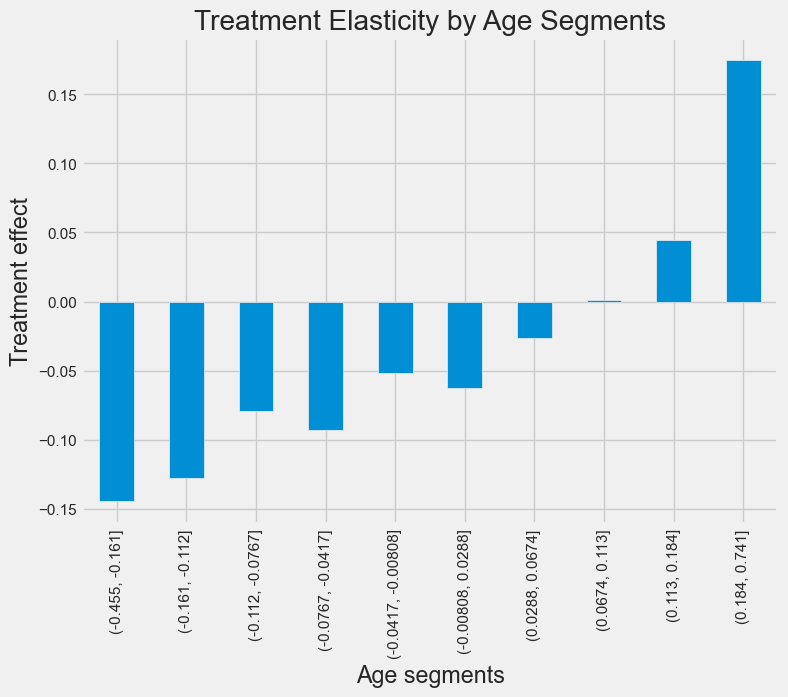

In [254]:
elasticity_by_segment(test_predictions, "treatment_effect_model", 10).plot.bar()
plt.title("Treatment Elasticity by Age Segments")
plt.xlabel("Age segments")
plt.ylabel("Treatment effect")

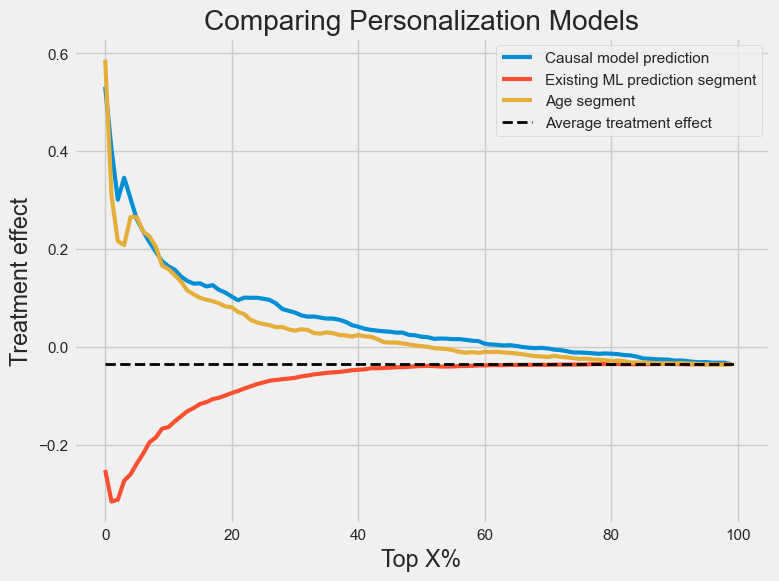

In [255]:
cumulative_elasticity_te_model = cumulative_continuous_treatment_effect(test_predictions,
                                                                        "treatment_effect_model",
                                                                        100)

plt.plot(cumulative_elasticity_te_model, label="Causal model prediction", lw=3)
plt.plot(cte_continuous_prediction, label="Existing ML prediction segment", lw=3)
plt.plot(cte_continuous_age, label="Age segment", lw=3)
plt.hlines(elast(test_predictions, "profit", "discount"), 0, 100, linestyles="--", color="black", label="Average treatment effect", lw=2)
plt.plot()
plt.title("Comparing Personalization Models")
plt.xlabel("Top X%")
plt.ylabel("Treatment effect")
plt.legend()

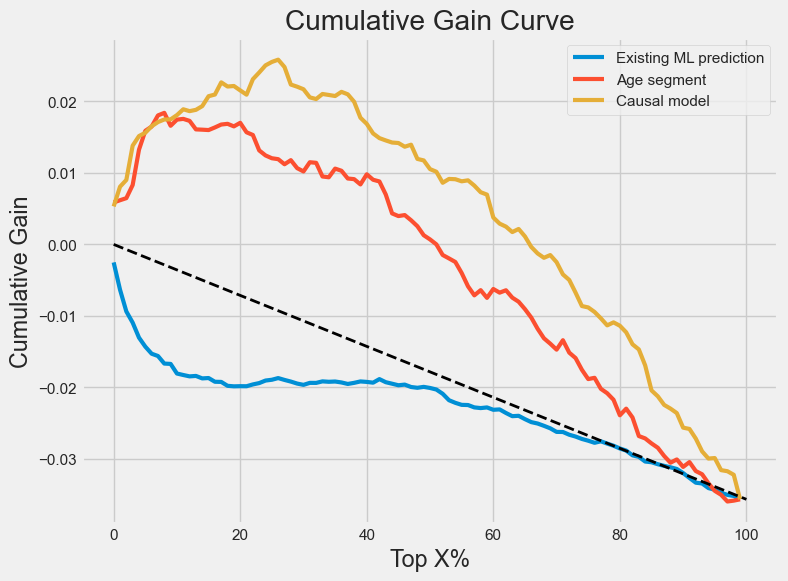

In [256]:
cumulative_gain_te_model = cumulative_continous_treatment_gain(test_predictions,
                                                               "treatment_effect_model",
                                                               100)

plt.plot(gain_continuous_prediction, label="Existing ML prediction", lw=3)
plt.plot(gain_continuous_age, label="Age segment", lw=3)
plt.plot(cumulative_gain_te_model, label="Causal model", lw=3)
plt.plot([0, 100], [0, elast(test_predictions, "profit", "discount")], linestyle="--", color="black", lw=2)
plt.title("Cumulative Gain Curve")
plt.ylabel("Cumulative Gain")
plt.xlabel("Top X%")
plt.legend()